In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import time
from tree.base import DecisionTree
from metrics import *


In [9]:
# Set random seed for reproducibility
np.random.seed(42)

In [10]:
# Function to generate synthetic binary data
def generate_synthetic_data(N, M, data_type):
    if data_type == "DIDO":
        X = pd.DataFrame(np.random.randint(0, 2, size=(N, M))).apply(lambda x: x.astype('category'))
        y = pd.Series(np.random.randint(0, 2, size=N)).astype('category')
    elif data_type == "DIRO":
        X = pd.DataFrame(np.random.randint(0, 2, size=(N, M))).apply(lambda x: x.astype('category'))
        y = pd.Series(np.random.randn(N))
    elif data_type == "RIDO":
        X = pd.DataFrame(np.random.randn(N, M))
        y = pd.Series(np.random.randint(0, 2, size=N)).astype('category')
    else:  # RIRO
        X = pd.DataFrame(np.random.randn(N, M))
        y = pd.Series(np.random.randn(N))
    return X, y


In [11]:
# Function to calculate average time (and std) taken by fit() and predict() for different N and M for different cases of DT
def time_calc(X: pd.DataFrame, y:pd.Series, criteria)->None:
    N = len(X)
    M = len(y)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=42)
    tree = DecisionTree(criterion=criteria)
    st_time = time.time()
    tree.fit(X_train,y_train)
    end_time = time.time()
    fit_time = (end_time - st_time) * 1e3
    st_time = time.time()
    y_pred = tree.predict(X_test)
    end_time = time.time()
    pred_time = (end_time - st_time ) * 1e3
    return fit_time, pred_time



In [12]:
# Function to plot results
def plot_result(varying_param, start, end, other_param, criterion):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    input_types = ["DIDO", "DIRO", "RIDO", "RIRO"]

    if varying_param == "N":
        x_values = np.arange(start, end, 50)
    else:
        x_values = np.arange(start, end, 5)

    for input_type in input_types:
        y_values, y_values2 = [], []

        for i in x_values:
            X, y = generate_synthetic_data(i if varying_param == "N" else other_param,
                                    other_param if varying_param == "N" else i, input_type)
            t, t2 = [], []

            for _ in range(100):
                fit_time, pred_time = time_calc(X, y, criterion)
                t.append(fit_time)
                t2.append(pred_time)

            y_values.append(np.mean(t))
            y_values2.append(np.mean(t2))

        axes[0].plot(x_values, y_values, label=input_type)
        axes[1].plot(x_values, y_values2, label=input_type)

    axes[0].set_title(f"Fit Time, Criterion: {criterion}")
    axes[1].set_title(f"Predict Time, Criterion: {criterion}")
    axes[0].set_xlabel(varying_param)
    axes[1].set_xlabel(varying_param)
    axes[0].set_ylabel("Time (ms)")
    axes[1].set_ylabel("Time (ms)")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()


In [13]:
# 3D Surface plot
def plot_3d_surface(M_values, N_values, data_type, criterion):
    M, N = np.meshgrid(M_values, N_values)
    time_matrix = np.full((len(N_values), len(M_values)), np.nan)

    for i, M_val in enumerate(M_values):
        for j, N_val in enumerate(N_values):
            X, y = generate_synthetic_data(int(N_val), int(M_val), data_type)
            time_matrix[j, i] = time_calc(X, y, criterion)[0]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(M, N, time_matrix, cmap='viridis')

    ax.set_xlabel('M values')
    ax.set_ylabel('N values')
    ax.set_zlabel('Time (ms)')
    ax.set_title(f'3D Plot: {data_type}')
    fig.colorbar(surface, ax=ax, label='Time (ms)')
    plt.show()



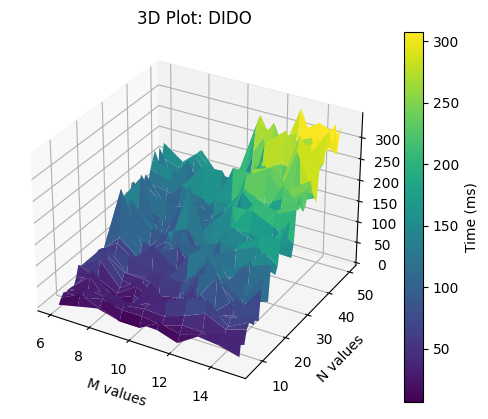

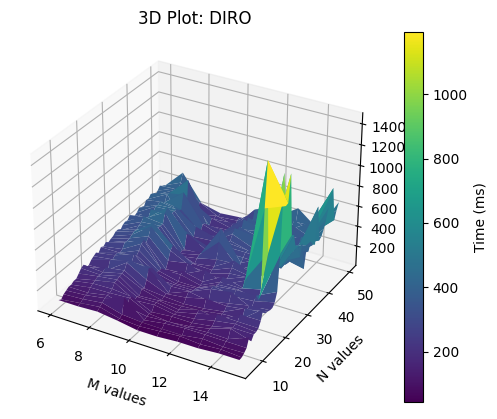

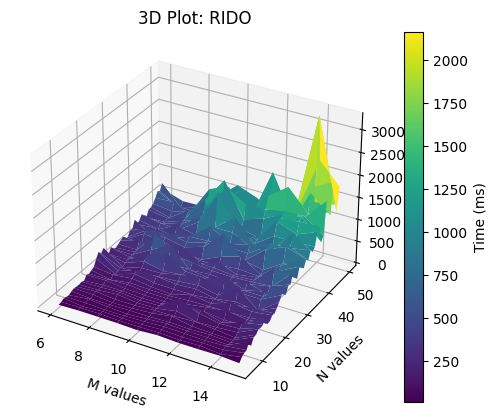

In [14]:
# Generate 3D plots
M_values = np.linspace(6, 15, 10)
N_values = np.linspace(6, 50, 45)
M, N = np.meshgrid(M_values, N_values)
time_matrix = np.full((45, 10), np.nan)

for data_type in ["DIDO", "DIRO", "RIDO", "RIRO"]:
    plot_3d_surface(M_values, N_values, data_type, "gini")




KeyboardInterrupt: 

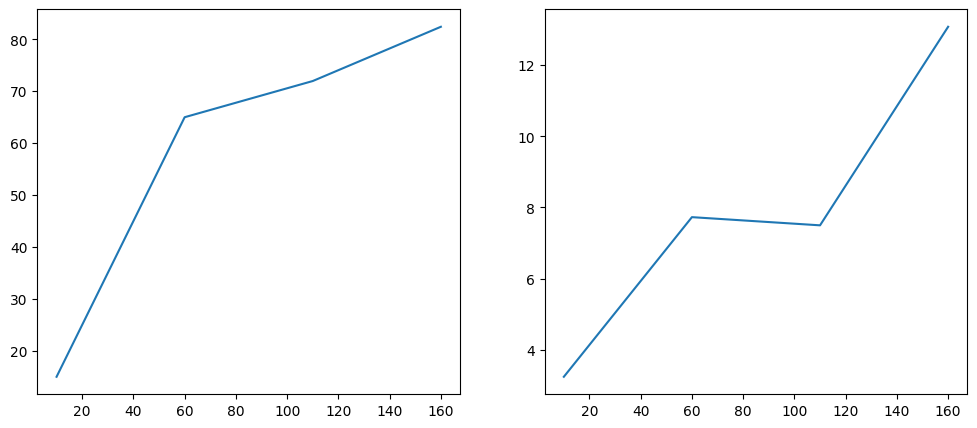

In [ ]:
# Plot for varying N and M
plot_result("N", 10, 200, 5, "gini")
plot_result("M", 2, 25, 100, "gini")
plot_result("N",10,200,5,"information_gain")
plot_result("M",2,25,100,"information_gain")

Let's take case wise examples:   
For time taken to learn the tree:
 
We can make two generalizations:  
(1): Real input cases take higher amount of time than discrete inputs.  
(2): Real output cases takes slightly higher amount of time than their discrete output counterparts.
      
Explanation: As we can see clearly from the first graph, Real Input Real Output (RIRO) data type grows at a faster rate than all the other type of data. This is because for each depth in decision tree, for real output, we need O(n<sup>2</sup>) whereas, for discrete outputs, we need O(n) time to make another level in the tree. Thus, RIRO takes significantly more time than RIDO, and DIRO takes higher time than DIDO which is visible near the larger values of N.  
Another reason why real input cases takes significantly more than discrete ones, is because we have only binary features in case of discrete inputs, which means the maximum depth of the tree will be 2, whereas in real input cases, depth of tree can go upto 5 (which is maximum depth set by us). This also means that fitting the data or making a decision tree with the data will take more time.


For time taken to predict:

Generalization:  
(1) Discrete input cases take slightly more time than real inputs (in ms).  
(2) Discrete output takes slightly higher time. 

This difference is very less than that seen in fit time. The more time taken by discrete input cases may be due to finding the particular key after traversing the dictionary to get the child TreeNode. This time is not spent in real input cases where the child node is chosen directly using if else statements.

In [ ]:
# User-defined input function
def user_defined_input():
    varying_param = input("Select a variable to vary (M or N): ")
    start = int(input(f"Enter the start of {varying_param}: "))
    end = int(input(f"Enter the end of {varying_param}: "))
    other_param = int(input(f"Select value for the other parameter (M or N): "))
    criterion = input("Select criterion (gini or entropy): ")
    plot_result(varying_param, start, end, other_param, criterion)

user_defined_input()